In [171]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np

In [172]:
with open('./data/LLMsuggestions_free_uncommented.json', 'r') as f1:
    LLMResults = json.load(f1)

with open('./data/allTables_free.json', 'r') as f2:
    MznResults = json.load(f2)

In [173]:
# --- Flatten LLMResults into llm_df ---
def ResultsFlattener(LLMResults):
    llm_rows = []
    for provider, models in (LLMResults or {}).items():
        if not isinstance(models, dict):
            continue
        for model, problems in models.items():
            if not isinstance(problems, dict):
                continue
            for problem, instances in problems.items():
                if not isinstance(instances, dict):
                    continue
                for instance, data in instances.items():
                    if not isinstance(data, dict):
                        top3_val = None
                        time_val = None
                    else:
                        top3_val = data.get('top3') if 'top3' in data else data.get('top_3') if 'top_3' in data else data.get('suggested') if 'suggested' in data else None
                        time_val = data.get('time_seconds') if 'time_seconds' in data else data.get('time') if 'time' in data else None
                    if isinstance(top3_val, list):
                        top3_list = top3_val
                        top3_str = ', '.join(map(str, top3_list)) if top3_list else None
                        top1 = top3_list[0] if top3_list else None
                    elif isinstance(top3_val, str):
                        parts = [p.strip() for p in top3_val.replace(';',',').split(',') if p.strip()]
                        top3_list = parts if parts else None
                        top3_str = ', '.join(parts) if parts else top3_val
                        top1 = parts[0] if parts else (top3_val or None)
                    else:
                        top3_list = None
                        top3_str = None
                        top1 = None
                    llm_rows.append({
                        'provider': provider,
                        'model': model,
                        'problem': problem,
                        'instance': instance,
                        'top3_list': top3_list,
                        'top3': top3_str,
                        'top1': top1,
                        'time_seconds': time_val
                    })

    llm_df = pd.DataFrame(llm_rows)
    if not llm_df.empty:
        llm_df['time_seconds'] = pd.to_numeric(llm_df['time_seconds'], errors='coerce')
    return llm_df

llm_df = ResultsFlattener(LLMResults)
print('LLM DataFrame shapes and example:')
print('llm_df.shape =', llm_df.shape)
display(llm_df.head(10))


LLM DataFrame shapes and example:
llm_df.shape = (1007, 8)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,gemini,gemini-2.5-flash,atsp,instance4_0p15,"[or-tools_cp-sat-free, cp_optimizer-free, chuf...","or-tools_cp-sat-free, cp_optimizer-free, chuff...",or-tools_cp-sat-free,24.238
1,gemini,gemini-2.5-flash,atsp,instance20_0p35,"[or-tools_cp-sat-free, cp_optimizer-free, chuf...","or-tools_cp-sat-free, cp_optimizer-free, chuff...",or-tools_cp-sat-free,27.641
2,gemini,gemini-2.5-flash,atsp,instance14_0p25,"[cp_optimizer-free, or-tools_cp-sat-free, chuf...","cp_optimizer-free, or-tools_cp-sat-free, chuff...",cp_optimizer-free,17.376
3,gemini,gemini-2.5-flash,atsp,instance1_0p05,"[or-tools_cp-sat-free, chuffed-free, choco-sol...","or-tools_cp-sat-free, chuffed-free, choco-solv...",or-tools_cp-sat-free,20.425
4,gemini,gemini-2.5-flash,atsp,instance11_0p25,"[or-tools_cp-sat-free, cp_optimizer-free, choc...","or-tools_cp-sat-free, cp_optimizer-free, choco...",or-tools_cp-sat-free,26.904
5,gemini,gemini-2.5-flash,black-hole,layout_17,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,16.390
6,gemini,gemini-2.5-flash,black-hole,layout_25,"[cp_optimizer-free, chuffed-free, or-tools_cp-...","cp_optimizer-free, chuffed-free, or-tools_cp-s...",cp_optimizer-free,15.309
7,gemini,gemini-2.5-flash,black-hole,layout_3,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,20.054
8,gemini,gemini-2.5-flash,black-hole,layout_14,"[or-tools_cp-sat-free, cp_optimizer-free, chuf...","or-tools_cp-sat-free, cp_optimizer-free, chuff...",or-tools_cp-sat-free,22.178
9,gemini,gemini-2.5-flash,black-hole,layout_27,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,22.277


In [174]:
rows = []

for problem, problem_data in MznResults.items():
    category = problem_data.get("category")
    
    for instance, solvers in problem_data.items():
        if instance == "category":
            continue  # skip category entry
        for solver_entry in solvers:
            rows.append({
                "Problem": problem,
                "Category": category,
                "Instance": instance,
                "Solver": solver_entry.get("Solver"),
                "Status": solver_entry.get("Status"),
                "Time": solver_entry.get("Time"),
                "Objective": solver_entry.get("Objective"),
                "Score": solver_entry.get("Score"),
                "Score Area": solver_entry.get("Score Area"),
            })

df = pd.DataFrame(rows)

# Optional: convert numeric columns
numeric_cols = ["Time", "Objective", "Score", "Score Area"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Inspect the result
display(df.head())
print(df.shape)

,Problem,Category,Instance,Solver,Status,Time,Objective,Score,Score Area
0,EchoSched,MIN,12-12-0-1_7,atlantis-free,UNK,1200000.0,NaN,0.00,1200000.00
1,EchoSched,MIN,12-12-0-1_7,cbc-free,S,1200000.0,12172.0,5.00,326862.67
2,EchoSched,MIN,12-12-0-1_7,choco-solver__cp_-free,SC,38449.0,12135.0,10.54,14001.39
3,EchoSched,MIN,12-12-0-1_7,choco-solver__cp-sat_-free,SC,48686.0,12135.0,10.03,17561.17
4,EchoSched,MIN,12-12-0-1_7,chuffed-free,SC,6508.0,12135.0,15.05,4352.61


(2000, 9)


### Solver Score Calculation

For each solver \( s \) and instance \( i \), we compute a **score** that reflects the solver’s performance according to the rules below.  
This metric applies to both **satisfaction** and **optimization** problems.

#### Definitions

- \( sol(s, i) \): status returned by the solver  
  (possible values: `S`, `C`, `ERR`, `UNK`, `UNSAT`, etc.)
- \( val(s, i) \): objective value obtained by the solver  
- \( best(i) \): best (optimal) objective value across all solvers for that instance  
- \( worst(i) \): worst (non-error) objective value across all solvers for that instance  
- \( category(i) \): either **MIN** or **MAX**, defining whether lower or higher objectives are better  

The mapping between MiniZinc statuses and the symbolic statuses in the formula is:

| Status | Meaning | Formula Status |
|---------|----------|----------------|
| `S`, `SC` | Found a feasible solution | `SAT` |
| `C` with best objective | Optimal or proven UNSAT | `OPT` |
| `ERR` | Error or crash | `ERR` |
| `UNK` | No answer within time limit | `UNK` |



### Formula (for Minimization)

$$
score(s,i) =
\begin{cases}
0 & \text{if } sol(s,i) \in \{UNK, ERR\} \\
1 & \text{if } sol(s,i) \in \{UNSAT, OPT\} \\
0.25 + 0.5 \cdot \frac{val(s,i) - worst(i)}{best(i) - worst(i)} & \text{if } sol(s,i) = SAT
\end{cases}
$$

For **maximization problems**, the ratio in the last term is inverted.

In [175]:
# Work on a copy
scored_df = df.copy()

# Normalize Status column
scored_df['Status'] = scored_df['Status'].astype(str).str.upper()

# Only consider numeric Objectives for best/worst computation
valid_mask = scored_df['Status'].isin(['S', 'C']) & scored_df['Objective'].notnull()
valid_objs = scored_df.loc[valid_mask, ['Problem', 'Instance', 'Objective', 'Category']]

# Compute best/worst per instance depending on MIN/MAX
def best_worst(group):
    cat = group['Category'].iloc[0].upper()
    if cat == 'MIN':
        best = group['Objective'].min()
        worst = group['Objective'].max()
    else:
        best = group['Objective'].max()
        worst = group['Objective'].min()
    return pd.Series({'best': best, 'worst': worst})

agg = valid_objs.groupby(['Problem', 'Instance']).apply(best_worst).reset_index()

# Merge back to the main dataframe
scored_df = scored_df.merge(agg, on=['Problem', 'Instance'], how='left')

# Determine solver-level labels (SAT vs OPT)
def solver_label(row):
    if row['Status'] in ['UNK', 'ERR']:
        return 'UNK'
    if row['Status'] in ['S', 'SC']:
        cat = row['Category'].upper()
        if cat == 'SAT':
            return 'OPT'
        if pd.isna(row['Objective']) or pd.isna(row['best']):
            return 'SAT'
        if cat == 'MIN' and row['Objective'] <= row['best']:
            return 'OPT'
        if cat == 'MAX' and row['Objective'] >= row['best']:
            return 'OPT'
        return 'SAT'
    return row['Status']

scored_df['DerivedStatus'] = scored_df.apply(solver_label, axis=1)

# Compute final score
def compute_score(row):
    stat = row['DerivedStatus']
    val = row['Objective']
    best = row['best']
    worst = row['worst']
    cat = str(row['Category']).upper()

    if stat in ['UNK', 'ERR']:
        return 0.0
    if stat in ['OPT']:
        return 1.0
    if stat == 'SAT' and pd.notnull(best) and pd.notnull(worst) and best != worst:
        if cat == 'MIN':
            return 0.25 + 0.5 * (val - worst) / (best - worst)
        elif cat == 'MAX':
            return 0.25 + 0.5 * (best - val) / (best - worst)
    return np.nan

scored_df['ComputedScore'] = scored_df.apply(compute_score, axis=1)
display(scored_df[scored_df['Problem'] == 'black-hole'])

/tmp/ipykernel_10289/2294925146.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = valid_objs.groupby(['Problem', 'Instance']).apply(best_worst).reset_index()


,Problem,Category,Instance,Solver,Status,Time,Objective,Score,Score Area,best,worst,DerivedStatus,ComputedScore
200,black-hole,SAT,layout_14,atlantis-free,UNK,1200000.0,NaN,0.00,1200000.0,NaN,NaN,UNK,0.0
201,black-hole,SAT,layout_14,cbc-free,UNK,1200000.0,NaN,0.00,1200000.0,NaN,NaN,UNK,0.0
202,black-hole,SAT,layout_14,choco-solver__cp_-free,S,6422.0,NaN,16.07,6422.0,NaN,NaN,OPT,1.0
203,black-hole,SAT,layout_14,choco-solver__cp-sat_-free,S,13428.0,NaN,15.03,13428.0,NaN,NaN,OPT,1.0
204,black-hole,SAT,layout_14,chuffed-free,S,687.0,NaN,19.00,687.0,NaN,NaN,OPT,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,black-hole,SAT,layout_3,picatsat-free,S,39746.0,NaN,13.00,39746.0,NaN,NaN,OPT,1.0
296,black-hole,SAT,layout_3,pumpkin-free,UNK,1200000.0,NaN,0.00,1200000.0,NaN,NaN,UNK,0.0
297,black-hole,SAT,layout_3,scip-free,UNK,1200000.0,NaN,0.00,1200000.0,NaN,NaN,UNK,0.0
298,black-hole,SAT,layout_3,sicstus_prolog-free,UNK,1200000.0,NaN,0.00,1200000.0,NaN,NaN,UNK,0.0


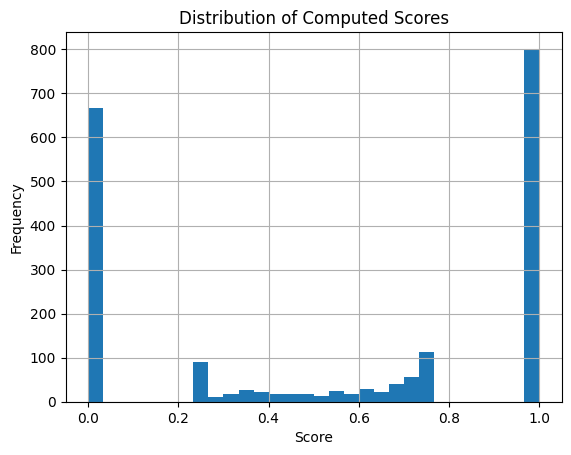

In [176]:
import matplotlib.pyplot as plt
scored_df['ComputedScore'].hist(bins=30)
plt.title('Distribution of Computed Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [177]:
def compute_llm_scores(llm_df, scored_df):
    llm_expanded = llm_df.copy()

    llm_expanded = llm_expanded[llm_expanded['top3_list'].notnull()].copy()
    llm_expanded = llm_expanded.explode('top3_list').rename(columns={'top3_list': 'Solver'}) 
    llm_expanded['Solver'] = llm_expanded['Solver'].astype(str)
    # Standardize matching keys
    llm_expanded['problem'] = llm_expanded['problem'].astype(str)
    llm_expanded['instance'] = llm_expanded['instance'].astype(str)
    scored_df['Problem'] = scored_df['Problem'].astype(str)
    scored_df['Instance'] = scored_df['Instance'].astype(str)
    scored_df['Solver'] = scored_df['Solver'].astype(str)

    # Merge: (problem, instance, solver)
    llm_scored = llm_expanded.merge(
        scored_df[['Problem', 'Instance', 'Solver', 'ComputedScore']],
        left_on=['problem', 'instance', 'Solver'],
        right_on=['Problem', 'Instance', 'Solver'],
        how='left'
    )

    llm_summary = (
        llm_scored
        .groupby(['provider', 'model'], as_index=False)['ComputedScore']
        .sum()
        .rename(columns={'ComputedScore': 'LLM_TotalScore'})
    )

    # Normalize by number of instances covered
    llm_summary['InstancesCovered'] = (
        llm_scored.groupby(['provider', 'model'])[['problem', 'instance']]
        .nunique()
        .reset_index(drop=True)['instance']
    )
    llm_summary['LLM_AvgScore'] = llm_summary['LLM_TotalScore'] / llm_summary['InstancesCovered']
    return llm_summary

llm_summary = compute_llm_scores(llm_df, scored_df)

display(llm_summary.sort_values('LLM_AvgScore', ascending=False))

,provider,model,LLM_TotalScore,InstancesCovered,LLM_AvgScore
13,groq,moonshotai/kimi-k2-instruct-0905,177.630619,75,2.368408
9,groq,meta-llama/llama-4-maverick-17b-128e-instruct,170.368064,72,2.366223
14,groq,openai/gpt-oss-120b,174.683137,74,2.360583
6,groq,groq/compound-mini,82.575723,35,2.359306
12,groq,moonshotai/kimi-k2-instruct,176.426088,75,2.352348
8,groq,llama-3.3-70b-versatile,22.360164,10,2.236016
5,groq,groq/compound,19.943697,9,2.215966
1,gemini,gemini-2.5-flash,186.339120,86,2.166734
15,groq,openai/gpt-oss-20b,162.476305,75,2.166351
0,gemini,gemini-2.0-flash,145.038062,67,2.164747


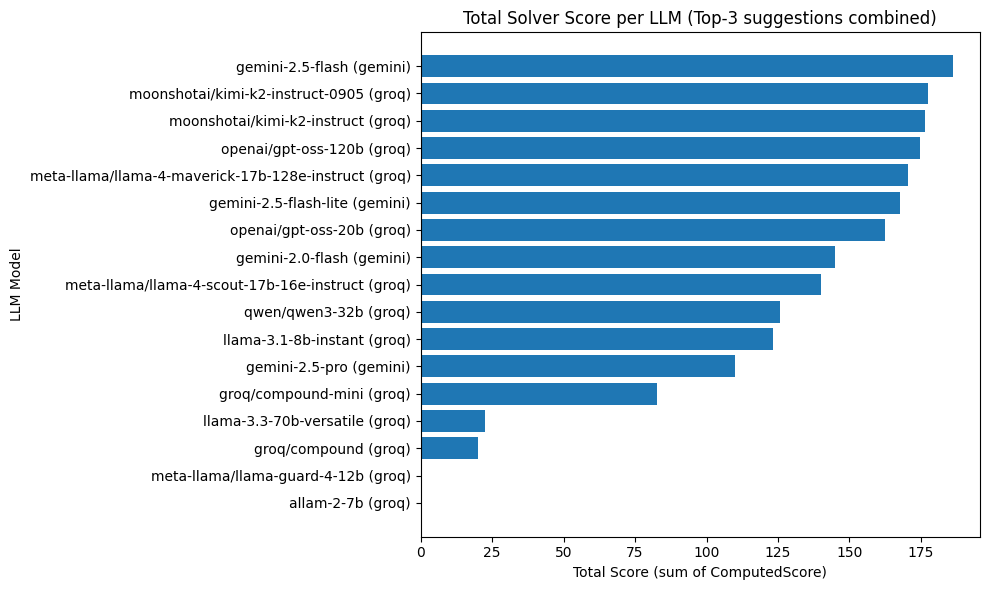

In [178]:
# Sort by total score
plot_df = llm_summary.sort_values('LLM_TotalScore', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(
    plot_df['model'] + " (" + plot_df['provider'] + ")", 
    plot_df['LLM_TotalScore']
)
plt.title("Total Solver Score per LLM (Top-3 suggestions combined)")
plt.xlabel("Total Score (sum of ComputedScore)")
plt.ylabel("LLM Model")
plt.tight_layout()
plt.show()

In [179]:
def compute_top1_llm_scores(llm_df, scored_df):
    # --- Extract Top-1 predictions only ---
    llm_top1 = llm_df.copy()
    llm_top1 = llm_top1[llm_top1['top1'].notnull()].copy()
    llm_top1 = llm_top1.rename(columns={'top1': 'Solver'})
    llm_top1['Solver'] = llm_top1['Solver'].astype(str)

    # --- Standardize key names and merge with solver scores ---
    scored_df['Problem'] = scored_df['Problem'].astype(str)
    scored_df['Instance'] = scored_df['Instance'].astype(str)
    scored_df['Solver'] = scored_df['Solver'].astype(str)

    llm_top1['problem'] = llm_top1['problem'].astype(str)
    llm_top1['instance'] = llm_top1['instance'].astype(str)

    llmTSD_scored = llm_top1.merge(
        scored_df[['Problem', 'Instance', 'Solver', 'ComputedScore']],
        left_on=['problem', 'instance', 'Solver'],
        right_on=['Problem', 'Instance', 'Solver'],
        how='left'
    )

    # --- Aggregate by (provider, model) ---
    llm_top1_summary = (
        llmTSD_scored
        .groupby(['provider', 'model'], as_index=False)
        .agg(
            LLM_Top1_TotalScore=('ComputedScore', 'sum'),
            LLM_Top1_AvgScore=('ComputedScore', 'mean'),
            InstancesCovered=('instance', 'nunique')
        )
    )

    # --- Sort descending by average score ---
    llm_top1_summary = llm_top1_summary.sort_values('LLM_Top1_TotalScore', ascending=False)
    return llm_top1_summary, llmTSD_scored

llm_top1_summary, llm_top1_scored = compute_top1_llm_scores(llm_df, scored_df)
display(llm_top1_summary)


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered
2,gemini,gemini-2.5-flash-lite,67.448500,0.832698,85
1,gemini,gemini-2.5-flash,65.629788,0.781307,85
12,groq,moonshotai/kimi-k2-instruct-0905,60.940287,0.834798,75
11,groq,moonshotai/kimi-k2-instruct,60.122616,0.858895,75
13,groq,openai/gpt-oss-120b,59.422634,0.814009,74
14,groq,openai/gpt-oss-20b,59.410434,0.861021,75
9,groq,meta-llama/llama-4-maverick-17b-128e-instruct,59.053489,0.843621,72
10,groq,meta-llama/llama-4-scout-17b-16e-instruct,55.561696,0.817084,69
0,gemini,gemini-2.0-flash,49.512659,0.761733,67
15,groq,qwen/qwen3-32b,46.934275,0.853350,65


In [180]:
# Extract missing instances for a specific LLM model
model_to_check = 'gemini-2.5-flash'
llm_model_data = llm_top1_scored[llm_top1_scored['model'] == model_to_check]
# find all (problem, instance) pairs in scored_df, then remove those covered by this LLM model
scored_pairs = (
    scored_df[['Problem', 'Instance']]
    .drop_duplicates()
    .rename(columns={'Problem': 'problem', 'Instance': 'instance'})
    .astype(str)
)

covered_pairs = llm_model_data[['problem', 'instance']].drop_duplicates().astype(str)

missing_instances = (
    scored_pairs.merge(covered_pairs, on=['problem', 'instance'], how='left', indicator=True)
    .query("_merge == 'left_only'")
    .drop(columns=['_merge'])
    .reset_index(drop=True)
)
print(f"Missing instances for model '{model_to_check}':")
display(missing_instances)

Missing instances for model 'gemini-2.5-flash':


,problem,instance
0,groupsplitter,u12g2pref0
1,groupsplitter,u12g2pref2
2,groupsplitter,u15g1pref2
3,groupsplitter,u15g3pref0
4,groupsplitter,u15g5pref1
5,hitori,h11-1
6,proteindesign12,1HZ5.12p.19aa.usingEref_self
7,proteindesign12,1HZ5.12p.9aa.usingEref_self
8,proteindesign12,1UBI.13p.19aa.usingEref_self
9,proteindesign12,1UBI.13p.9aa.usingEref_self_x


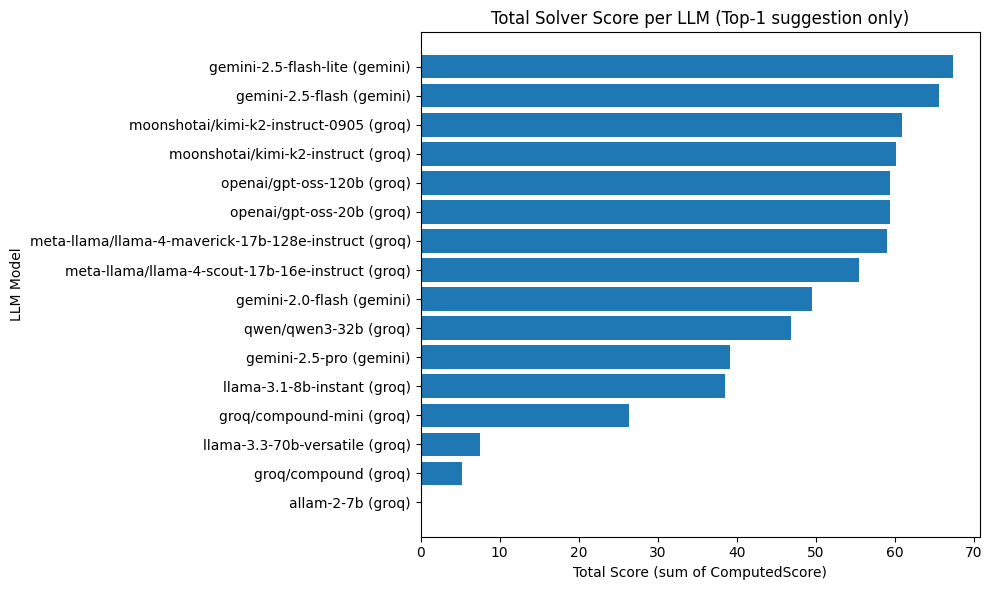

In [181]:
# Sort by total score
plot_df = llm_top1_summary.sort_values('LLM_Top1_TotalScore', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(
    plot_df['model'] + " (" + plot_df['provider'] + ")", 
    plot_df['LLM_Top1_TotalScore']
)
plt.title("Total Solver Score per LLM (Top-1 suggestion only)")
plt.xlabel("Total Score (sum of ComputedScore)")
plt.ylabel("LLM Model")
plt.tight_layout()
plt.show()

### Closed-Gap (CG) Metric Calculation

The **closed-gap (cg)** metric measures how close a solver selection (in this case, the LLM’s chosen solver) is to the *Virtual Best Solver* (VBS), normalized against the *Single Best Solver* (SBS).

#### Formula

$$
cg = \frac{score_{all}(AS) - score_{all}(SBS)}{score_{all}(VBS) - score_{all}(SBS)}
$$

where:
- **AS** = Algorithm Selector (the solver predicted by the LLM)
- **VBS** = Virtual Best Solver — the solver that achieves the best score on each instance
- **SBS** = Single Best Solver — the single solver that performs best overall across the dataset  
  (in our case: `SBS = 'or-tools_cp-sat-free'`)

In [182]:
def compute_closed_gap(llm_top1_scored, scored_df):
    SBS_SOLVER = 'or-tools_cp-sat-free'

    cg_results = []

    # Compute VBS scores for all instances once
    vbs_df = (
        scored_df.groupby(['Problem', 'Instance'], as_index=False)['ComputedScore']
        .max()
        .rename(columns={'ComputedScore': 'VBS_Score'})
    )

    for (prov, mod), group in llm_top1_scored.groupby(['provider', 'model']):
        # Instances this model actually made predictions for
        covered = group[['problem', 'instance']].drop_duplicates()
        
        # Subset SBS and VBS to same instance set
        vbs_sub = vbs_df.merge(
            covered,
            left_on=['Problem', 'Instance'],
            right_on=['problem', 'instance'],
            how='inner'
        )
        sbs_sub = scored_df[
            (scored_df['Solver'] == SBS_SOLVER)
            & (scored_df['Problem'].isin(covered['problem']))
            & (scored_df['Instance'].isin(covered['instance']))
        ]
        
        # Compute total scores normalized over same instance set
        score_AS = group['ComputedScore'].sum()
        score_VBS = vbs_sub['VBS_Score'].sum()
        score_SBS = sbs_sub['ComputedScore'].sum()

        # Compute closed gap
        cg = (score_AS - score_SBS) / (score_VBS - score_SBS) if (score_VBS - score_SBS) != 0 else float('nan')

        cg_results.append({
            'provider': prov,
            'model': mod,
            'InstancesCovered': len(covered),
            'AS': score_AS,
            'SBS': score_SBS,
            'VBS': score_VBS,
            'ClosedGap': cg,
        })
    return cg_results

cg_results = compute_closed_gap(llm_top1_scored, scored_df)

cg_df = pd.DataFrame(cg_results).sort_values('ClosedGap', ascending=False)
display(cg_df)

,provider,model,InstancesCovered,AS,SBS,VBS,ClosedGap
2,gemini,gemini-2.5-flash-lite,85,67.448500,67.585568,83.0,-0.008892
3,gemini,gemini-2.5-pro,51,39.140862,40.201589,50.0,-0.108255
1,gemini,gemini-2.5-flash,85,65.629788,67.585568,83.0,-0.126880
0,gemini,gemini-2.0-flash,67,49.512659,53.857047,66.0,-0.357770
12,groq,moonshotai/kimi-k2-instruct-0905,75,60.940287,64.256236,73.0,-0.379236
9,groq,meta-llama/llama-4-maverick-17b-128e-instruct,72,59.053489,62.371511,70.0,-0.434951
11,groq,moonshotai/kimi-k2-instruct,75,60.122616,64.256236,73.0,-0.472751
10,groq,meta-llama/llama-4-scout-17b-16e-instruct,69,55.561696,59.481700,67.0,-0.521395
13,groq,openai/gpt-oss-120b,74,59.422634,63.791641,72.0,-0.532263
14,groq,openai/gpt-oss-20b,75,59.410434,64.256236,73.0,-0.554201


## General classification of single solvers based on score

In [183]:
score_solvers = []

for solver, group in scored_df.groupby('Solver'):
    total_score = group['ComputedScore'].sum()
    score_solvers.append({
        'Solver': solver,
        'TotalScore': total_score
    })
score_solvers_df = pd.DataFrame(score_solvers).sort_values('TotalScore', ascending=False)
display(score_solvers_df)



,Solver,TotalScore
13,or-tools_cp-sat-free,81.299457
4,chuffed-free,75.962662
15,picatsat-free,71.683307
2,choco-solver__cp-sat_-free,70.345290
10,huub-free,69.805679
11,izplus-free,67.758311
3,choco-solver__cp_-free,63.587601
16,pumpkin-free,61.835880
5,cp_optimizer-free,61.400375
8,gurobi-free,60.227161


## Confrontation between single solvers and LLMs 
### extraction of the five best models which will be the only one considered from now on

In [184]:
# We put together both solver total score and LLM total score, to see how LLMs compare to single solvers
llm_totscores = llm_top1_summary.copy()

# Rename LLM_Top1_TotalScore to TotalScore and model to Solver
llm_totscores = llm_totscores.rename(columns={'LLM_Top1_TotalScore':'TotalScore', 'model': 'Solver'})
# We drop LLM_Top1_AvgScore	InstancesCovered and provider columns
llm_totscores = llm_totscores.drop(columns=['LLM_Top1_AvgScore', 'InstancesCovered', 'provider'])

frames = [llm_totscores, score_solvers_df]
generalScores = pd.concat(frames)

generalScores_df = pd.DataFrame(generalScores).sort_values('TotalScore', ascending=False)
display(generalScores_df) 
display(llm_totscores)

solver_list = llm_totscores['Solver'].head().astype(str).tolist()
print('==== Top 5 LLM Solvers ====')
print(solver_list)

,Solver,TotalScore
13,or-tools_cp-sat-free,81.299457
4,chuffed-free,75.962662
15,picatsat-free,71.683307
2,choco-solver__cp-sat_-free,70.345290
10,huub-free,69.805679
11,izplus-free,67.758311
2,gemini-2.5-flash-lite,67.448500
1,gemini-2.5-flash,65.629788
3,choco-solver__cp_-free,63.587601
16,pumpkin-free,61.835880


,Solver,TotalScore
2,gemini-2.5-flash-lite,67.448500
1,gemini-2.5-flash,65.629788
12,moonshotai/kimi-k2-instruct-0905,60.940287
11,moonshotai/kimi-k2-instruct,60.122616
13,openai/gpt-oss-120b,59.422634
14,openai/gpt-oss-20b,59.410434
9,meta-llama/llama-4-maverick-17b-128e-instruct,59.053489
10,meta-llama/llama-4-scout-17b-16e-instruct,55.561696
0,gemini-2.0-flash,49.512659
15,qwen/qwen3-32b,46.934275


==== Top 5 LLM Solvers ====
['gemini-2.5-flash-lite', 'gemini-2.5-flash', 'moonshotai/kimi-k2-instruct-0905', 'moonshotai/kimi-k2-instruct', 'openai/gpt-oss-120b']


## Top Models
### From now on we'll only bve using the yop 5 performing models:
'gemini-2.5-flash-lite', 'gemini-2.5-flash', 'moonshotai/kimi-k2-instruct', 'moonshotai/kimi-k2-instruct-0905', 'openai/gpt-oss-120b'
Data aquired from those LLMs where reached via truncation of input problems to keep request within each LLM's rate limits.

In [185]:
with open('./data/LLMsuggestions_free_uncommented_True.json', 'r') as f3:
    LLMResultsTop = json.load(f3)

with open('./data/LLMsuggestions_free_uncommented_top_desc.json', 'r') as f4:
    LLMResultsTopDesc = json.load(f4)

with open('./data/LLMsuggestions_chat.json', 'r') as f5:
    LLMResultsTopSDesc = json.load(f5)

with open('./data/LLMsuggestions_chat_Pdesc.json', 'r') as f6:
    LLMResultsTopSDPD = json.load(f6)

In [186]:
# --- Flatten different LLMResults variants ---

llmT_df = ResultsFlattener(LLMResultsTop)
print('Top LLM DataFrame shapes and example:')
print('llmT_df.shape =', llmT_df.shape)
display(llmT_df.head(10))

llmTD_df = ResultsFlattener(LLMResultsTopDesc)
print('Top+Desc LLM DataFrame shapes and example:')
print('llmTD_df.shape =', llmTD_df.shape)
display(llmTD_df.head(10))

llmTSD_df = ResultsFlattener(LLMResultsTopSDesc)
print('Top+SDesc LLM DataFrame shapes and example:')
print('llmTSD_df.shape =', llmTSD_df.shape)
display(llmTSD_df.head(10))

llmTSDPD_df = ResultsFlattener(LLMResultsTopSDPD)
print('Top+SDesc+PDesc LLM DataFrame shapes and example:')
print('llmTSDPD_df.shape =', llmTSDPD_df.shape)
display(llmTSDPD_df.head(10))

Top LLM DataFrame shapes and example:
llmT_df.shape = (500, 8)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,gemini,gemini-2.5-flash-lite,atsp,instance14_0p25,"[or-tools_cp-sat-free, choco-solver__cp-sat_-f...","or-tools_cp-sat-free, choco-solver__cp-sat_-fr...",or-tools_cp-sat-free,2.176
1,gemini,gemini-2.5-flash-lite,atsp,instance11_0p25,"[or-tools_cp-sat-free, choco-solver__cp_-free,...","or-tools_cp-sat-free, choco-solver__cp_-free, ...",or-tools_cp-sat-free,1.853
2,gemini,gemini-2.5-flash-lite,atsp,instance1_0p05,"[or-tools_cp-sat-free, cp_optimizer-free, choc...","or-tools_cp-sat-free, cp_optimizer-free, choco...",or-tools_cp-sat-free,1.448
3,gemini,gemini-2.5-flash-lite,atsp,instance4_0p15,"[or-tools_cp-sat-free, choco-solver__cp_-free,...","or-tools_cp-sat-free, choco-solver__cp_-free, ...",or-tools_cp-sat-free,1.934
4,gemini,gemini-2.5-flash-lite,atsp,instance20_0p35,"[or-tools_cp-sat-free, chuffed-free, choco-sol...","or-tools_cp-sat-free, chuffed-free, choco-solv...",or-tools_cp-sat-free,4.900
5,gemini,gemini-2.5-flash-lite,black-hole,layout_14,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,10.943
6,gemini,gemini-2.5-flash-lite,black-hole,layout_27,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,1.392
7,gemini,gemini-2.5-flash-lite,black-hole,layout_17,"[choco-solver__cp_-par, chuffed-free, or-tools...","choco-solver__cp_-par, chuffed-free, or-tools_...",choco-solver__cp_-par,1.245
8,gemini,gemini-2.5-flash-lite,black-hole,layout_25,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,1.827
9,gemini,gemini-2.5-flash-lite,black-hole,layout_3,"[or-tools_cp-sat-free, choco-solver__cp_-par, ...","or-tools_cp-sat-free, choco-solver__cp_-par, c...",or-tools_cp-sat-free,1.021


Top+Desc LLM DataFrame shapes and example:
llmTD_df.shape = (475, 8)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,groq,moonshotai/kimi-k2-instruct-0905,atsp,instance14_0p25,"[or-tools_cp-sat-free, chuffed-free, choco-sol...","or-tools_cp-sat-free, chuffed-free, choco-solv...",or-tools_cp-sat-free,2.941
1,groq,moonshotai/kimi-k2-instruct-0905,atsp,instance11_0p25,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,0.468
2,groq,moonshotai/kimi-k2-instruct-0905,atsp,instance1_0p05,"[chuffed-free, or-tools_cp-sat-free, cp_optimi...","chuffed-free, or-tools_cp-sat-free, cp_optimiz...",chuffed-free,0.398
3,groq,moonshotai/kimi-k2-instruct-0905,atsp,instance4_0p15,"[chuffed-free, or-tools_cp-sat-free, choco-sol...","chuffed-free, or-tools_cp-sat-free, choco-solv...",chuffed-free,0.923
4,groq,moonshotai/kimi-k2-instruct-0905,atsp,instance20_0p35,"[or-tools_cp-sat-free, choco-solver__cp-sat_-f...","or-tools_cp-sat-free, choco-solver__cp-sat_-fr...",or-tools_cp-sat-free,0.585
5,groq,moonshotai/kimi-k2-instruct-0905,black-hole,layout_14,"[chuffed-free, or-tools_cp-sat-free, huub-free]","chuffed-free, or-tools_cp-sat-free, huub-free",chuffed-free,0.454
6,groq,moonshotai/kimi-k2-instruct-0905,black-hole,layout_27,"[chuffed-free, or-tools_cp-sat-free, jacop-free]","chuffed-free, or-tools_cp-sat-free, jacop-free",chuffed-free,0.640
7,groq,moonshotai/kimi-k2-instruct-0905,black-hole,layout_17,"[chuffed-free, or-tools_cp-sat-free, jacop-free]","chuffed-free, or-tools_cp-sat-free, jacop-free",chuffed-free,0.669
8,groq,moonshotai/kimi-k2-instruct-0905,black-hole,layout_25,"[chuffed-free, or-tools_cp-sat-free, gurobi-free]","chuffed-free, or-tools_cp-sat-free, gurobi-free",chuffed-free,0.652
9,groq,moonshotai/kimi-k2-instruct-0905,black-hole,layout_3,"[chuffed-free, or-tools_cp-sat-free, gurobi-free]","chuffed-free, or-tools_cp-sat-free, gurobi-free",chuffed-free,0.728


Top+SDesc LLM DataFrame shapes and example:
llmTSD_df.shape = (500, 8)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,chat,gemini-2.5-flash-lite,atsp,instance11_0p25,"[atlantis-free, cbc-free, choco-solver__cp_-free]","atlantis-free, cbc-free, choco-solver__cp_-free",atlantis-free,NaN
1,chat,gemini-2.5-flash-lite,atsp,instance14_0p25,"[atlantis-free, cbc-free, choco-solver__cp_-free]","atlantis-free, cbc-free, choco-solver__cp_-free",atlantis-free,NaN
2,chat,gemini-2.5-flash-lite,atsp,instance1_0p05,"[atlantis-free, cbc-free, choco-solver__cp_-free]","atlantis-free, cbc-free, choco-solver__cp_-free",atlantis-free,NaN
3,chat,gemini-2.5-flash-lite,atsp,instance20_0p35,"[atlantis-free, cbc-free, choco-solver__cp_-free]","atlantis-free, cbc-free, choco-solver__cp_-free",atlantis-free,NaN
4,chat,gemini-2.5-flash-lite,atsp,instance4_0p15,"[atlantis-free, cbc-free, choco-solver__cp_-free]","atlantis-free, cbc-free, choco-solver__cp_-free",atlantis-free,NaN
5,chat,gemini-2.5-flash-lite,black-hole,layout_14,"[choco-solver__cp_-free, cp_optimizer-free, or...","choco-solver__cp_-free, cp_optimizer-free, or-...",choco-solver__cp_-free,NaN
6,chat,gemini-2.5-flash-lite,black-hole,layout_17,"[choco-solver__cp_-free, cp_optimizer-free, or...","choco-solver__cp_-free, cp_optimizer-free, or-...",choco-solver__cp_-free,NaN
7,chat,gemini-2.5-flash-lite,black-hole,layout_25,"[choco-solver__cp_-free, cp_optimizer-free, or...","choco-solver__cp_-free, cp_optimizer-free, or-...",choco-solver__cp_-free,NaN
8,chat,gemini-2.5-flash-lite,black-hole,layout_27,"[choco-solver__cp_-free, cp_optimizer-free, or...","choco-solver__cp_-free, cp_optimizer-free, or-...",choco-solver__cp_-free,NaN
9,chat,gemini-2.5-flash-lite,black-hole,layout_3,"[choco-solver__cp_-free, cp_optimizer-free, or...","choco-solver__cp_-free, cp_optimizer-free, or-...",choco-solver__cp_-free,NaN


Top+SDesc+PDesc LLM DataFrame shapes and example:
llmTSDPD_df.shape = (499, 8)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,chat,gemini-2.5-flash-lite,atsp,instance11_0p25,"[choco-solver__cp_-free, cp_optimizer-free, gu...","choco-solver__cp_-free, cp_optimizer-free, gur...",choco-solver__cp_-free,NaN
1,chat,gemini-2.5-flash-lite,atsp,instance14_0p25,"[choco-solver__cp_-free, cp_optimizer-free, gu...","choco-solver__cp_-free, cp_optimizer-free, gur...",choco-solver__cp_-free,NaN
2,chat,gemini-2.5-flash-lite,atsp,instance1_0p05,"[choco-solver__cp_-free, cp_optimizer-free, gu...","choco-solver__cp_-free, cp_optimizer-free, gur...",choco-solver__cp_-free,NaN
3,chat,gemini-2.5-flash-lite,atsp,instance20_0p35,"[choco-solver__cp_-free, cp_optimizer-free, gu...","choco-solver__cp_-free, cp_optimizer-free, gur...",choco-solver__cp_-free,NaN
4,chat,gemini-2.5-flash-lite,atsp,instance4_0p15,"[choco-solver__cp_-free, cp_optimizer-free, gu...","choco-solver__cp_-free, cp_optimizer-free, gur...",choco-solver__cp_-free,NaN
5,chat,gemini-2.5-flash-lite,black-hole,layout_14,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,NaN
6,chat,gemini-2.5-flash-lite,black-hole,layout_17,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,NaN
7,chat,gemini-2.5-flash-lite,black-hole,layout_25,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,NaN
8,chat,gemini-2.5-flash-lite,black-hole,layout_27,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,NaN
9,chat,gemini-2.5-flash-lite,black-hole,layout_3,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,NaN


In [187]:
# --- Compute scores for different LLMResults variants ---
llmT_summary = compute_llm_scores(llmT_df, scored_df)
print('Top LLM Summary:')
display(llmT_summary.sort_values('LLM_AvgScore', ascending=False))

llmTD_summary = compute_llm_scores(llmTD_df, scored_df)
print('Top+Desc LLM Summary:')
display(llmTD_summary.sort_values('LLM_AvgScore', ascending=False))

llmTSD_summary = compute_llm_scores(llmTSD_df, scored_df)
print('Top+SDesc LLM Summary:')
display(llmTSD_summary.sort_values('LLM_AvgScore', ascending=False))

llmTSDPD_summary = compute_llm_scores(llmTSDPD_df, scored_df)
print('Top+SDesc+PDesc LLM Summary:')
display(llmTSDPD_summary.sort_values('LLM_AvgScore', ascending=False))

Top LLM Summary:


,provider,model,LLM_TotalScore,InstancesCovered,LLM_AvgScore
4,groq,openai/gpt-oss-120b,225.419460,100,2.254195
3,groq,moonshotai/kimi-k2-instruct-0905,223.944929,100,2.239449
2,groq,moonshotai/kimi-k2-instruct,223.099825,100,2.230998
0,gemini,gemini-2.5-flash,206.392609,100,2.063926
1,gemini,gemini-2.5-flash-lite,193.275003,100,1.932750


Top+Desc LLM Summary:


,provider,model,LLM_TotalScore,InstancesCovered,LLM_AvgScore
3,groq,moonshotai/kimi-k2-instruct-0905,226.237099,100,2.262371
4,groq,openai/gpt-oss-120b,224.755782,100,2.247558
2,groq,moonshotai/kimi-k2-instruct,212.413735,100,2.124137
0,gemini,gemini-2.5-flash,157.072607,75,2.094301
1,gemini,gemini-2.5-flash-lite,202.147465,100,2.021475


Top+SDesc LLM Summary:


,provider,model,LLM_TotalScore,InstancesCovered,LLM_AvgScore
0,chat,gemini-2.5-flash,221.766726,100,2.217667
2,chat,moonshotai/kimi-k2-instruct,219.128052,100,2.191281
3,chat,moonshotai/kimi-k2-instruct-0905,209.394399,100,2.093944
1,chat,gemini-2.5-flash-lite,179.977846,100,1.799778
4,chat,openai/gpt-oss-120b,179.698332,100,1.796983


Top+SDesc+PDesc LLM Summary:


,provider,model,LLM_TotalScore,InstancesCovered,LLM_AvgScore
0,chat,gemini-2.5-flash,217.954101,100,2.179541
3,chat,moonshotai/kimi-k2-instruct-0905,214.048860,100,2.140489
2,chat,moonshotai/kimi-k2-instruct,198.184965,99,2.001868
1,chat,gemini-2.5-flash-lite,195.416820,100,1.954168
4,chat,openai/gpt-oss-120b,193.328966,100,1.933290


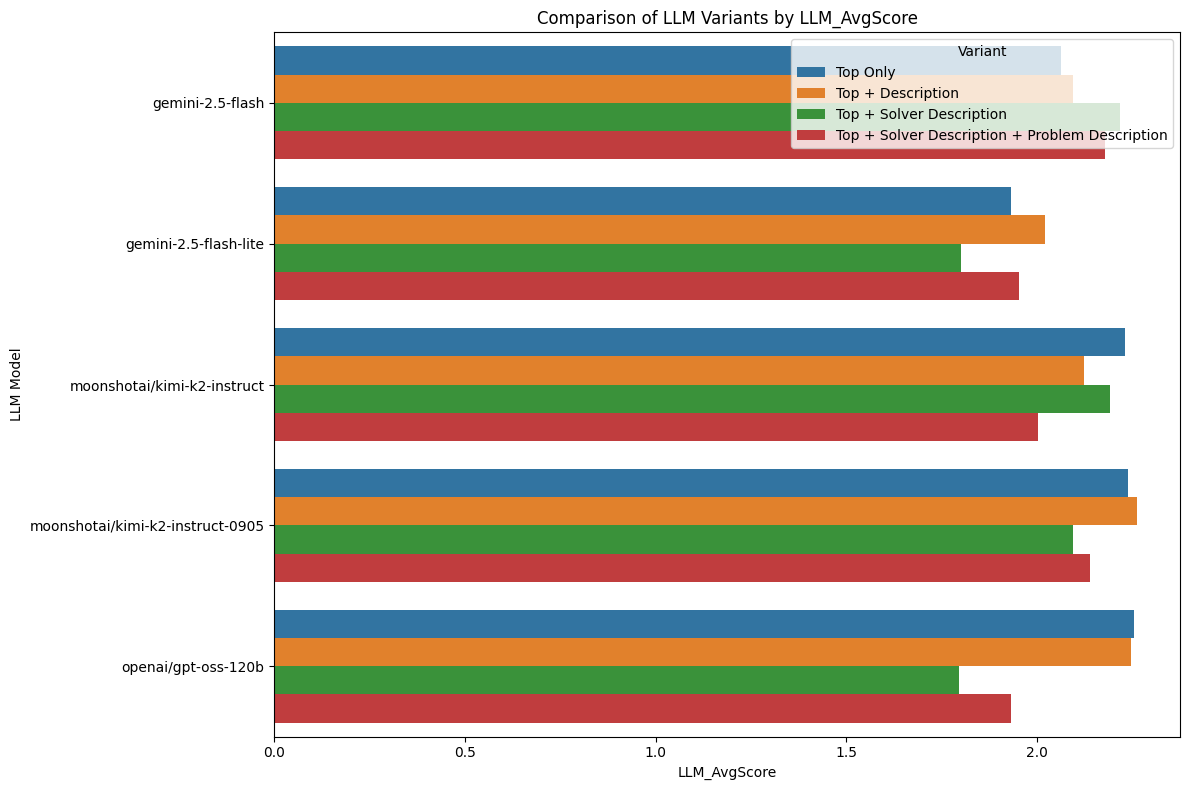

In [188]:
# --- Plot comparison of LLM variants ---
def plot_llm_variant_comparison(summaries, variant_names, label):
    combined_df = pd.DataFrame()
    for summary, name in zip(summaries, variant_names):
        temp_df = summary.copy()
        temp_df['Variant'] = name
        combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=combined_df,
        x=label,
        y='model',
        hue='Variant'
    )
    plt.title('Comparison of LLM Variants by ' + label)
    plt.xlabel(label)
    plt.ylabel('LLM Model')
    plt.legend(title='Variant')
    plt.tight_layout()
    plt.show()

plot_llm_variant_comparison(
    [llmT_summary, llmTD_summary, llmTSD_summary, llmTSDPD_summary],
    ['Top Only', 'Top + Description', 'Top + Solver Description', 'Top + Solver Description + Problem Description'],
    'LLM_AvgScore'
)

In [189]:
# --- Compute Top-1 LLM scores for different variants ---
llmT_top1_summary, llmT_top1_scored = compute_top1_llm_scores(llmT_df, scored_df)
print('Top LLM Top-1 Summary:')
display(llmT_top1_summary)

llmTD_top1_summary, llmTD_top1_scored = compute_top1_llm_scores(llmTD_df, scored_df)
print('Top+Desc LLM Top-1 Summary:')
display(llmTD_top1_summary)

llmTSD_top1_summary, llmTSD_top1_scored = compute_top1_llm_scores(llmTSD_df, scored_df)
print('Top+SDesc LLM Top-1 Summary:')
display(llmTSD_top1_summary)

llmTSDPD_top1_summary, llmTSDPD_top1_scored = compute_top1_llm_scores(llmTSDPD_df, scored_df)
print('Top+SDesc+PDesc LLM Top-1 Summary:')
display(llmTSDPD_top1_summary)

Top LLM Top-1 Summary:


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered
1,gemini,gemini-2.5-flash-lite,77.277879,0.796679,100
0,gemini,gemini-2.5-flash,77.013464,0.802224,98
4,groq,openai/gpt-oss-120b,75.994607,0.759946,100
3,groq,moonshotai/kimi-k2-instruct-0905,75.982892,0.791488,100
2,groq,moonshotai/kimi-k2-instruct,74.703498,0.762281,100


Top+Desc LLM Top-1 Summary:


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered
3,groq,moonshotai/kimi-k2-instruct-0905,76.690567,0.790624,100
4,groq,openai/gpt-oss-120b,73.496956,0.742393,100
1,gemini,gemini-2.5-flash-lite,73.377932,0.764353,100
2,groq,moonshotai/kimi-k2-instruct,71.385935,0.759425,100
0,gemini,gemini-2.5-flash,55.779352,0.785625,73


Top+SDesc LLM Top-1 Summary:


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered
2,chat,moonshotai/kimi-k2-instruct,81.299457,0.812995,100
3,chat,moonshotai/kimi-k2-instruct-0905,81.299457,0.812995,100
0,chat,gemini-2.5-flash,76.261651,0.762617,100
4,chat,openai/gpt-oss-120b,73.108812,0.738473,100
1,chat,gemini-2.5-flash-lite,59.589395,0.595894,100


Top+SDesc+PDesc LLM Top-1 Summary:


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered
0,chat,gemini-2.5-flash,81.386695,0.813867,100
3,chat,moonshotai/kimi-k2-instruct-0905,81.299457,0.812995,100
4,chat,openai/gpt-oss-120b,81.095936,0.819151,100
2,chat,moonshotai/kimi-k2-instruct,78.299457,0.790904,99
1,chat,gemini-2.5-flash-lite,66.398076,0.663981,100


In [190]:
# Ensure consistent string types
llmTSDPD_top1_scored['problem'] = llmTSDPD_top1_scored['problem'].astype(str)
llmTSDPD_top1_scored['instance'] = llmTSDPD_top1_scored['instance'].astype(str)
scored_df['Problem'] = scored_df['Problem'].astype(str)
scored_df['Instance'] = scored_df['Instance'].astype(str)

# Rows where the merge produced no ComputedScore (NaN)
missing = llmTSDPD_top1_scored[llmTSDPD_top1_scored['ComputedScore'].isna()].copy()
print(f"Total missing scored entries after merge: {len(missing)}")

# Summary by (provider, model)
missing_summary = (
    missing
    .groupby(['provider', 'model'], as_index=False)
    .agg(
        MissingInstances=('instance', 'nunique'),
        MissingRows=('instance', 'size')
    )
    .sort_values('MissingInstances', ascending=False)
)
print("Missing summary by provider/model:")
display(missing_summary)

# Build a lookup of available solvers (as strings) for each (Problem, Instance)
solvers_lookup = (
    scored_df
    .groupby(['Problem', 'Instance'])['Solver']
    .apply(lambda s: sorted(set(map(str, s))))
    .to_dict()
)

if not missing.empty:
    # Add available solvers for context to help debug mismatch causes
    def available_solvers(row):
        key = (row['problem'], row['instance'])
        return solvers_lookup.get(key, [])

    missing['AvailableSolvers'] = missing.apply(available_solvers, axis=1)

    # Show distinct missing entries with useful columns
    display( missing)
else:
    print('No missing computed-score rows found in llm_top1_scored.')

# Additionally: show scored instances that the LLM never covered at all (optional)
all_instances = set(zip(scored_df['Problem'], scored_df['Instance']))
covered_by_llm = set(zip(llmTSD_top1_scored['problem'], llmTSD_top1_scored['instance']))
not_covered = sorted(list(all_instances - covered_by_llm))
print(f"\nInstances present in scored_df but not covered by any top1 in the LLM data: {len(not_covered)} (showing up to 50)")
for prob, inst in not_covered[:50]:
    print(prob, inst)

Total missing scored entries after merge: 1
Missing summary by provider/model:


,provider,model,MissingInstances,MissingRows
0,chat,openai/gpt-oss-120b,1,1


,provider,model,problem,instance,top3_list,top3,Solver,time_seconds,Problem,Instance,ComputedScore,AvailableSolvers
416,chat,openai/gpt-oss-120b,cgt,cgt_3_h39_r0.05_s1_3,"[choco-solver__cp_-par, or-tools_cp-sat_ls-fre...","choco-solver__cp_-par, or-tools_cp-sat_ls-free...",choco-solver__cp_-par,NaN,NaN,NaN,NaN,"[atlantis-free, cbc-free, choco-solver__cp-sat..."



Instances present in scored_df but not covered by any top1 in the LLM data: 0 (showing up to 50)


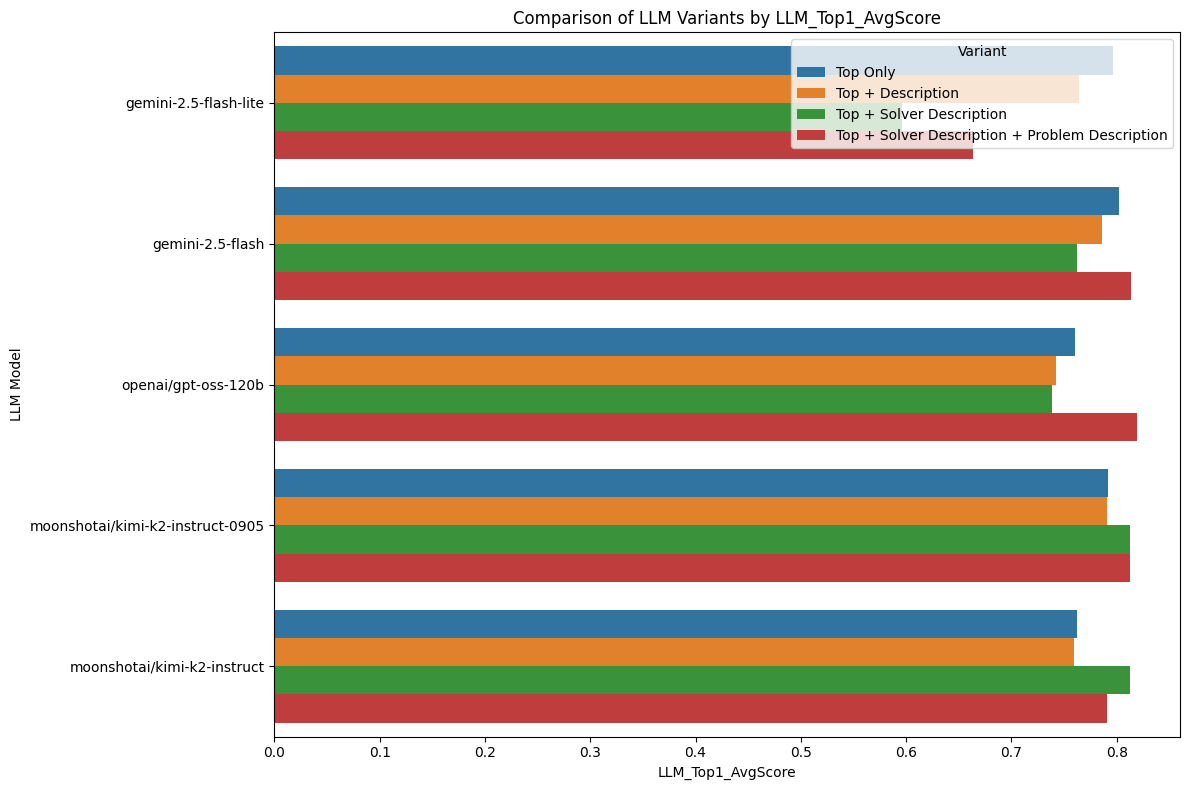

In [191]:
# --- Plot comparison of LLM top1 score variants ---
plot_llm_variant_comparison(
    [llmT_top1_summary, llmTD_top1_summary, llmTSD_top1_summary, llmTSDPD_top1_summary],
    ['Top Only', 'Top + Description', 'Top + Solver Description', 'Top + Solver Description + Problem Description'],
    'LLM_Top1_AvgScore'
)

In [192]:
# --- compute closed gap for different LLM variants ---
llmT_cg_results = compute_closed_gap(llmT_top1_scored, scored_df)
llmT_cg_df = pd.DataFrame(llmT_cg_results).sort_values('ClosedGap', ascending=False)
print('Top LLM Closed Gap:')
display(llmT_cg_df)

llmTD_cg_results = compute_closed_gap(llmTD_top1_scored, scored_df)
llmTD_cg_df = pd.DataFrame(llmTD_cg_results).sort_values('ClosedGap', ascending=False)
print('Top+Desc LLM Closed Gap:')
display(llmTD_cg_df)

llmTSD_cg_results = compute_closed_gap(llmTSD_top1_scored, scored_df)
llmTSD_cg_df = pd.DataFrame(llmTSD_cg_results).sort_values('ClosedGap', ascending=False)
print('Top+SDesc LLM Closed Gap:')
display(llmTSD_cg_df)

llmTSDPD_cg_results = compute_closed_gap(llmTSDPD_top1_scored, scored_df)
llmTSDPD_cg_df = pd.DataFrame(llmTSDPD_cg_results).sort_values('ClosedGap', ascending=False)
print('Top+SDesc+PDesc LLM Closed Gap:')
display(llmTSDPD_cg_df)

Top LLM Closed Gap:


,provider,model,InstancesCovered,AS,SBS,VBS,ClosedGap
0,gemini,gemini-2.5-flash,98,77.013464,79.674457,97.0,-0.153588
1,gemini,gemini-2.5-flash-lite,100,77.277879,81.299457,99.0,-0.227201
4,groq,openai/gpt-oss-120b,100,75.994607,81.299457,99.0,-0.299700
3,groq,moonshotai/kimi-k2-instruct-0905,100,75.982892,81.299457,99.0,-0.300362
2,groq,moonshotai/kimi-k2-instruct,100,74.703498,81.299457,99.0,-0.372642


Top+Desc LLM Closed Gap:


,provider,model,InstancesCovered,AS,SBS,VBS,ClosedGap
3,groq,moonshotai/kimi-k2-instruct-0905,100,76.690567,81.299457,99.0,-0.260381
0,gemini,gemini-2.5-flash,73,55.779352,59.306265,72.0,-0.277847
4,groq,openai/gpt-oss-120b,100,73.496956,81.299457,99.0,-0.440806
1,gemini,gemini-2.5-flash-lite,100,73.377932,81.299457,99.0,-0.447530
2,groq,moonshotai/kimi-k2-instruct,100,71.385935,81.299457,99.0,-0.560069


Top+SDesc LLM Closed Gap:


,provider,model,InstancesCovered,AS,SBS,VBS,ClosedGap
2,chat,moonshotai/kimi-k2-instruct,100,81.299457,81.299457,99.0,8.028485e-16
3,chat,moonshotai/kimi-k2-instruct-0905,100,81.299457,81.299457,99.0,8.028485e-16
0,chat,gemini-2.5-flash,100,76.261651,81.299457,99.0,-2.846131e-01
4,chat,openai/gpt-oss-120b,100,73.108812,81.299457,99.0,-4.627341e-01
1,chat,gemini-2.5-flash-lite,100,59.589395,81.299457,99.0,-1.226519e+00


Top+SDesc+PDesc LLM Closed Gap:


,provider,model,InstancesCovered,AS,SBS,VBS,ClosedGap
0,chat,gemini-2.5-flash,100,81.386695,81.299457,99.0,4.928542e-03
3,chat,moonshotai/kimi-k2-instruct-0905,100,81.299457,81.299457,99.0,8.028485e-16
4,chat,openai/gpt-oss-120b,100,81.095936,81.299457,99.0,-1.149801e-02
2,chat,moonshotai/kimi-k2-instruct,99,78.299457,80.299457,98.0,-1.129909e-01
1,chat,gemini-2.5-flash-lite,100,66.398076,81.299457,99.0,-8.418601e-01


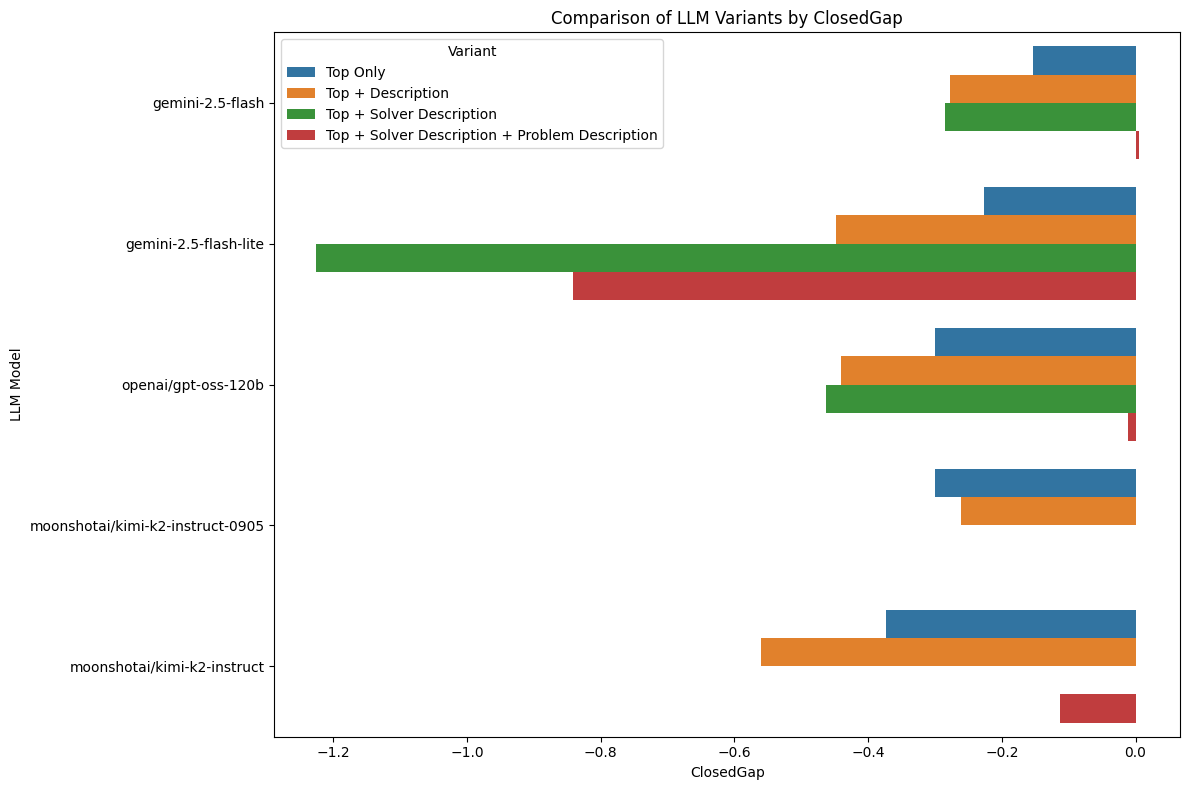

In [193]:
# --- Plot comparison of closedgap in LLM variants ---
plot_llm_variant_comparison(
    [llmT_cg_df, llmTD_cg_df, llmTSD_cg_df, llmTSDPD_cg_df],
    ['Top Only', 'Top + Description', 'Top + Solver Description', 'Top + Solver Description + Problem Description'],
    'ClosedGap'
)